## Semantic segmentation tests

In [1]:
# read data from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install segmentation models package
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00


In [3]:
import os
import tensorflow as tf
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import normalize
from keras.metrics import MeanIoU
from natsort import natsorted
import tqdm

from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

Segmentation Models: using `tf.keras` framework.


In [4]:
print(tf.config.list_physical_devices('GPU'))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# directory = "/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/Semantic-Segmentation/train_test_data"
directory = "/content/drive/MyDrive/train_test_data"

In [14]:
# resize images
size_x = 384
size_y = 384

# number of classes for segmentation: background, needle, oocyte and spermatozoid
n_classes = 4

In [15]:
train_list = glob.glob(f"{directory}/raw/*.*")
train_list_sorted = natsorted(train_list,reverse=False)

mask_list = glob.glob(f"{directory}/vis/*.*")
mask_list_sorted = natsorted(mask_list,reverse=False)

In [16]:
# capture training image info as a list
train_images = []

for train_path in train_list_sorted:
  img = cv2.imread(train_path, 1)
  img = cv2.resize(img, (size_x, size_y))
  train_images.append(img)

# convert list to array for machine learning processing
train_images = np.array(train_images)
# print(len(train_images))

In [17]:
# capture mask/label info as a list
train_masks = []

for mask_path in mask_list_sorted:
  mask = cv2.imread(mask_path, 0)
  mask = cv2.resize(mask, (size_x, size_y), interpolation = cv2.INTER_NEAREST)  # otherwise ground truth changes due to interpolation
  train_masks.append(mask)

# convert list to array for machine learning processing
train_masks = np.array(train_masks)
#print(len(train_masks))

### Data augmentation

In [18]:
# function to augment data

def augment_data(images, masks):
    augmented_images = []
    augmented_masks = []

    # iterate over list of images and masks
    for x, y in zip(images, masks):
        augmented_images.append(x)
        augmented_masks.append(y)

        aug = CenterCrop(size_x, size_y, p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented['image']
        y1 = augmented['mask']

        augmented_images.append(x1)
        augmented_masks.append(y1)

        aug = RandomRotate90(p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        augmented_images.append(x2)
        augmented_masks.append(y2)

        aug =GridDistortion(p=1.0)
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']

        augmented_images.append(x3)
        augmented_masks.append(y3)

        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']

        augmented_images.append(x4)
        augmented_masks.append(y4)

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x5 = augmented['image']
        y5 = augmented['mask']

        augmented_images.append(x5)
        augmented_masks.append(y5)

    return augmented_images, augmented_masks

In [19]:
augmented_images, augmented_masks = augment_data(train_images, train_masks)

train_images = augmented_images
train_images = np.array(train_images)

train_masks = augmented_masks
train_masks = np.array(train_masks)

In [20]:
#encode labels but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# print("unique train masks: ", np.unique(train_masks))
# print("unique train masks after encoding: ", np.unique(train_masks_encoded_original_shape))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# train_images = np.expand_dims(train_images, axis=3)
# train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.1, random_state = 42)

In [23]:
b_test = 0
n_test = 0
o_test = 0
s_test = 0

for y in y_test:
  b_test += y.size - np.count_nonzero(y)
  n_test += np.count_nonzero(y == 1)
  o_test += np.count_nonzero(y == 2)
  s_test += np.count_nonzero(y == 3)

In [24]:
classes_count_mean = [0,0,0,0]

classes_count_mean[0] = b_test/len(y_test)
classes_count_mean[1] = n_test/len(y_test)
classes_count_mean[2] = o_test/len(y_test)
classes_count_mean[3] = s_test/len(y_test)

classes_count_mean = [1/x for x in classes_count_mean]

classess_weights = classes_count_mean / np.linalg.norm(classes_count_mean)

In [25]:
# print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [26]:
n_classes=4
activation='softmax'

LR = 0.001
optim = tf.keras.optimizers.legacy.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss(class_weights=np.array(classess_weights))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(class_weights=classess_weights, threshold=0.5),
           sm.metrics.FScore(threshold=0.5),
           sm.metrics.Precision(threshold=0.5),
           sm.metrics.Recall(threshold=0.5)]

### Training

In [27]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)
# model = sm.PSPNet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.1,
                              patience=10, min_lr=0.00001)
#print(model.summary())


history=model.fit(X_train,
        y_train_cat,
        batch_size=16,
        epochs=100,
        verbose=1,
        callbacks=[callback, reduce_lr],
        validation_data=(X_test, y_test_cat))


model_in_mem = model

94592056/94592056 [==============================] - 2s 0us/step
Epoch 1/100
90/90 [==============================] - 117s 961ms/step - loss: 0.9994 - iou_score: 0.0114 - f1-score: 0.5496 - precision: 0.8270 - recall: 0.5648 - val_loss: 1.0385 - val_iou_score: 0.0056 - val_f1-score: 0.3941 - val_precision: 0.7693 - val_recall: 0.3867 - lr: 0.0010
Epoch 2/100
90/90 [==============================] - 74s 824ms/step - loss: 0.8808 - iou_score: 0.0912 - f1-score: 0.7718 - precision: 0.8140 - recall: 0.7547 - val_loss: 1.7206 - val_iou_score: 1.4732e-04 - val_f1-score: 0.1107 - val_precision: 0.8211 - val_recall: 0.2500 - lr: 0.0010
Epoch 3/100
90/90 [==============================] - 74s 825ms/step - loss: 0.8488 - iou_score: 0.1132 - f1-score: 0.8204 - precision: 0.8486 - recall: 0.8002 - val_loss: 0.9730 - val_iou_score: 0.0461 - val_f1-score: 0.4619 - val_precision: 0.5914 - val_recall: 0.5012 - lr: 0.0010
Epoch 4/100
90/90 [==============================] - 74s 825ms/step - loss: 0.842

In [28]:
model_in_mem.save('unet_softmax_1500_resnet50.hdf5')
from google.colab import files
files.download('unet_softmax_1500_resnet50.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

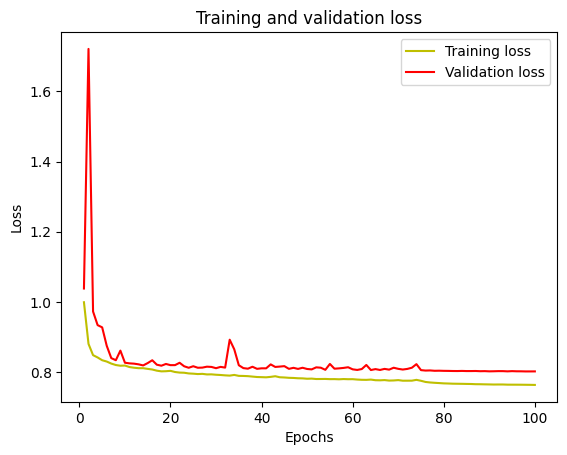

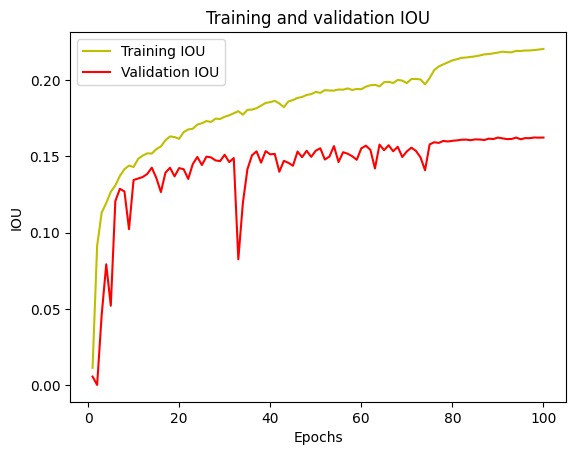

In [29]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

5/5 [==============================] - 14s 325ms/step
Mean IoU = 0.8496392
[[1.6185591e+07 3.4598000e+04 1.2986000e+05 6.0000000e+00]
 [2.7910000e+04 4.7511000e+05 1.3311000e+04 1.5840000e+03]
 [1.2614500e+05 1.3945000e+04 6.5708140e+06 1.7800000e+02]
 [1.6500000e+02 3.0010000e+03 9.4400000e+02 9.7980000e+03]]
IoU for class1 is:  0.98069084
IoU for class2 is:  0.83431816
IoU for class3 is:  0.9585157
IoU for class4 is:  0.6250319


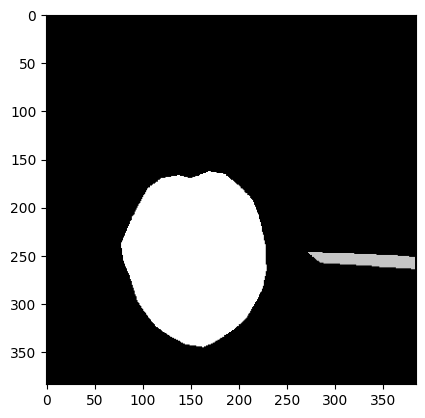

In [30]:
from keras.models import load_model
from sklearn import metrics

# set compile=False as we are not loading it for training, only for prediction.
# model = load_model('psp_softmax_1500_resnet50.hdf5', compile=False)
model = model_in_mem

# IoU
y_pred2=model.predict(X_test)
y_pred2_argmax=np.argmax(y_pred2, axis=3)

# using built in keras function
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# to calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

# verify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 23ms/step


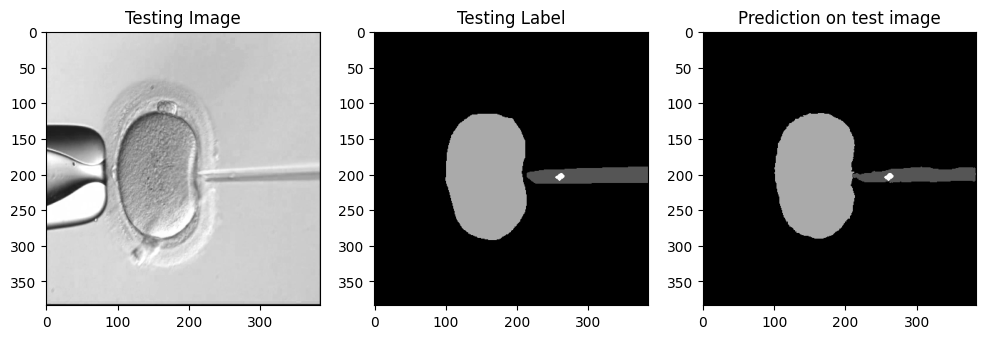

In [32]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

import torch
import torch.nn as nn
import torch.nn.functional as F

def pixel_accuracy(output, gt):
  with torch.no_grad():
    output = torch.from_numpy(output).float()
    gt = torch.from_numpy(gt).float()

    # apply softmax to the output to get the predicted probabilities for each class
    # then, select the class with the highest probability as the predicted class for each pixel
    output = torch.argmax(F.softmax(output, dim=1), dim=1)
    correct = torch.eq(output, gt).int()

    # compute the accuracy as the number of correctly predicted pixels divided by the total number of pixels
    accuracy = float(correct.sum()) / float(correct.numel())
  return accuracy

# print(pixel_accuracy(test_prediction1, ground_truth))


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0],vmin=0, vmax=3, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, vmin=0, vmax=3, cmap='gray')
plt.show()